In [1]:
!ls drive/MyDrive/DataSet/dataset

sample_submission.csv  test  test_ds.csv  train  train_ds.csv


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import time

In [3]:
train_df = pd.read_csv("drive/MyDrive/DataSet/dataset/train_ds.csv")
test_df = pd.read_csv("drive/MyDrive/DataSet/dataset/test_ds.csv")

In [4]:
train_df.Vehicle_condition
# Time_Orderd: TBD

0        2
1        0
2        0
3        1
4        1
        ..
45588    1
45589    1
45590    1
45591    1
45592    2
Name: Vehicle_condition, Length: 45593, dtype: int64

In [5]:
num_columns = ['Time_Order_picked', 'Delivery_person_Age', 'Delivery_person_Ratings', 
            'Restaurant_latitude', 'Restaurant_longitude', 
            'Delivery_location_latitude', 'Delivery_location_longitude', 
            'Vehicle_condition', 'multiple_deliveries', 'Order_Date']

categorical_features = ['Weather_conditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']

features = num_columns + categorical_features

In [6]:
def time_order(df):
  global num_columns
  #new = df["Time_Order_picked"].str.split(":", n = 1, expand = True)
  #df["Time_Order_picked"] = new[0] * 60 + new[1]
  ftr = [60,1]
  df["Time_Order_picked"] = df["Time_Order_picked"].apply(lambda x: sum([a*b for a,b in zip(ftr, map(int,x.split(':')))]))
  new = df["Order_Date"].str.split("-", n = 2, expand = True)
  df["Order_Date"]=new[0]
  df["Order_Month"]=new[1]
  df["Order_Year"]=new[2]
  num_columns.append("Order_Month")
  num_columns.append("Order_Month")
  #for col in ['Weather_conditions', 'Road_traffic_density', 'Festival', 'City']:
  #  df[col] = df[col].fillna('NotAvl')
  print(df.columns)
  return df

In [7]:
X_train_baseline = time_order(train_df.loc[:, features])
y_train_baseline = train_df.loc[:, "Time_taken_min"]


Index(['Time_Order_picked', 'Delivery_person_Age', 'Delivery_person_Ratings',
       'Restaurant_latitude', 'Restaurant_longitude',
       'Delivery_location_latitude', 'Delivery_location_longitude',
       'Vehicle_condition', 'multiple_deliveries', 'Order_Date',
       'Weather_conditions', 'Road_traffic_density', 'Type_of_order',
       'Type_of_vehicle', 'Festival', 'City', 'Order_Month', 'Order_Year'],
      dtype='object')


In [8]:
#X_train_baseline.columns
X_train_baseline.isnull().sum()

Time_Order_picked                 0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Vehicle_condition                 0
multiple_deliveries             993
Order_Date                        0
Weather_conditions              616
Road_traffic_density            601
Type_of_order                     0
Type_of_vehicle                   0
Festival                        228
City                           1200
Order_Month                       0
Order_Year                        0
dtype: int64

In [9]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
def nan_categorical_handle(X, categorical_features):
  for i in categorical_features:
    X[i] = X[i].fillna("notAvCat")
  
  return X


def nan_numeric_handle(X, num_columns):
  X.multiple_deliveries = X.multiple_deliveries.fillna(-1)
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(X)
  X = imp.transform(X)
  return X

X_train_baseline = nan_categorical_handle(X_train_baseline, categorical_features)
enc = OneHotEncoder(handle_unknown='ignore')
X_categorical = X_train_baseline.loc[:, categorical_features]
X_train_baseline = X_train_baseline.drop(categorical_features, axis=1)
enc.fit(X_categorical)
print(enc.categories_)
# enc.transform()
X_categorical = enc.transform(X_categorical)
X_categorical = pd.DataFrame(X_categorical.toarray())



X_train_baseline = nan_numeric_handle(X_train_baseline, num_columns)
#X_train_baseline.head()
#print(X_train_baseline.isnull().sum())



[array(['Cloudy', 'Fog', 'Sandstorms', 'Stormy', 'Sunny', 'Windy',
       'notAvCat'], dtype=object), array(['High', 'Jam', 'Low', 'Medium', 'notAvCat'], dtype=object), array(['Buffet', 'Drinks', 'Meal', 'Snack'], dtype=object), array(['bicycle', 'electric_scooter', 'motorcycle', 'scooter'],
      dtype=object), array(['No', 'Yes', 'notAvCat'], dtype=object), array(['Metropolitian', 'Semi-Urban', 'Urban', 'notAvCat'], dtype=object)]


In [10]:
X_train_baseline = pd.DataFrame(X_train_baseline)

df_all_cols = pd.concat([X_train_baseline, X_categorical], axis = 1)



In [11]:
df_all_cols.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64

## Models

To quickly evaulate if the changes made to the data made imporvements in the model

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from numpy import mean
from numpy import std


In [14]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_train_baseline, y_train_baseline, test_size=0.33, random_state=42)


def get_train_test_score(X_train, X_test, y_train, y_test, model):
  model.fit(X_train, y_train)
  print(f'{100*r2_score(y_train,model.predict(X_train))} training error')
  print(f'{100*r2_score(y_test,model.predict(X_test))} testing error')
  return model




In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_all_cols, y_train_baseline, test_size=0.33, random_state=42)

model = get_train_test_score(X_train, X_test, y_train, y_test, DecisionTreeRegressor())

100.0 training error
50.74516645153167 testing error


In [19]:
model = get_train_test_score(X_train, X_test, y_train, y_test, ElasticNet(alpha=0.0005, l1_ratio=.9))

56.36046318144648 training error
56.42055808660069 testing error


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.244e+03, tolerance: 2.693e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [20]:
model = get_train_test_score(X_train, X_test, y_train, y_test, KNeighborsRegressor())

46.2245663914139 training error
19.304976863537014 testing error


In [21]:
model = get_train_test_score(X_train, X_test, y_train, y_test, Lasso(alpha =0.0005))

56.3607203256417 training error
56.421105105174505 testing error


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.627e+03, tolerance: 2.693e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [22]:
model = get_train_test_score(X_train, X_test, y_train, y_test, DecisionTreeRegressor())

100.0 training error
50.41691442418013 testing error


In [17]:
model = get_train_test_score(X_train, X_test, y_train, y_test, LinearSVR())

33.8386082696044 training error
33.43383881496768 testing error


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Model tuning

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
model = get_train_test_score(X_train, X_test, y_train, y_test, RandomForestRegressor())
params_Knn = model.get_params()
print(params_Knn)

96.36435537951763 training error
73.83682162549749 testing error
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.kernel_ridge import KernelRidge
model_kr = get_train_test_score(X_train, X_test, y_train, y_test, KernelRidge())
params_Knn = model.get_params()
print(params_Knn)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_all_cols, y_train_baseline, test_size=0.33, random_state=42)

In [17]:
from sklearn.linear_model import HuberRegressor
model = get_train_test_score(X_train, X_test, y_train, y_test, HuberRegressor())
params_Knn = model.get_params()
print(params_Knn)

42.933206521644706 training error
42.523417217392 testing error
{'alpha': 0.0001, 'epsilon': 1.35, 'fit_intercept': True, 'max_iter': 100, 'tol': 1e-05, 'warm_start': False}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [18]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
model = get_train_test_score(X_train, X_test, y_train, y_test, AdaBoostRegressor())
params_Knn = model.get_params()
print(params_Knn)

54.59575106519365 training error
55.06562723680782 testing error
{'base_estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': None}


In [19]:
model = get_train_test_score(X_train, X_test, y_train, y_test, GradientBoostingRegressor())
params_Knn = model.get_params()
print(params_Knn)

70.95715562953012 training error
71.23593874732657 testing error
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
model = get_train_test_score(X_train, X_test, y_train, y_test, GaussianProcessRegressor())
params_Knn = model.get_params()
print(params_Knn)

In [23]:
# Building a stacking model to check on Performance 
from sklearn.ensemble import StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
level0 = list()
level0.append(('knn', GradientBoostingRegressor()))
level0.append(('cart', RandomForestRegressor()))
level0.append(('svm', ElasticNet(alpha=0.0005, l1_ratio=.9)))
level0.append(('lasso', Lasso(alpha =0.0005)))

# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(df_all_cols, y_train_baseline)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e+04, tolerance: 4.015e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+04, tolerance: 4.015e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

StackingRegressor(cv=5,
                  estimators=[('knn', GradientBoostingRegressor()),
                              ('cart', RandomForestRegressor()),
                              ('svm', ElasticNet(alpha=0.0005, l1_ratio=0.9)),
                              ('lasso', Lasso(alpha=0.0005))],
                  final_estimator=LinearRegression())

In [24]:
X_test_baseline = time_order(test_df.loc[:, features])
X_test_baseline = nan_categorical_handle(X_test_baseline, categorical_features)
X_categorical = X_test_baseline.loc[:, categorical_features]
X_test_baseline = X_test_baseline.drop(categorical_features, axis=1)
X_categorical = enc.transform(X_categorical)
X_categorical = pd.DataFrame(X_categorical.toarray())



X_test_baseline = nan_numeric_handle(X_test_baseline, num_columns)
X_test_baseline = pd.DataFrame(X_test_baseline)

df_all_cols_test = pd.concat([X_test_baseline, X_categorical], axis = 1)


Index(['Time_Order_picked', 'Delivery_person_Age', 'Delivery_person_Ratings',
       'Restaurant_latitude', 'Restaurant_longitude',
       'Delivery_location_latitude', 'Delivery_location_longitude',
       'Vehicle_condition', 'multiple_deliveries', 'Order_Date',
       'Weather_conditions', 'Road_traffic_density', 'Type_of_order',
       'Type_of_vehicle', 'Festival', 'City', 'Order_Month', 'Order_Year'],
      dtype='object')


(array([ 233., 1544., 2701., 2426., 1554., 1202., 1152.,  346.,  194.,
          47.]),
 array([ 9.1473486 , 13.64509164, 18.14283468, 22.64057772, 27.13832076,
        31.63606379, 36.13380683, 40.63154987, 45.12929291, 49.62703595,
        54.12477899]),
 <a list of 10 Patch objects>)

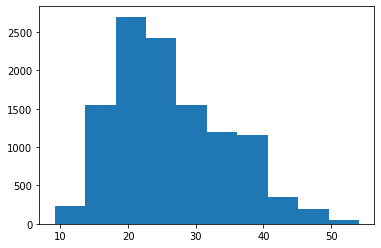

In [25]:
y_test_pred = model.predict(df_all_cols_test)
test_submit = pd.Series(y_test_pred, name="Time_taken (min)")
ID_column = test_df["ID"]
results = pd.concat([ID_column, test_submit], axis=1)
plt.hist(test_submit)

In [26]:
results.to_csv("stack_model.csv",index = False)

In [27]:
len(y_test_pred)

11399